In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from importlib import reload
import tqdm.notebook as tqdm

In [2]:
import fast_binning

In [3]:
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

## 12Hz blower frequency data
Data processing pipeline:
- Setup appropriate bins (semi-automated) 
- expand with additional variables 
- compute binning

The variable `dir_` should point to the directory containing all of the ATLAS metrics csv files for a build. 

In [4]:
dir_ = "onderive_data_2/12Hz/"

In [5]:
# grab a random file and use it to work out what metrics need to be included in the binning procedure.
test_path = dir_ + "layer360.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
var_labels = test.loc[:,"Photodiode":].columns.drop(["Z","Frame","Layer"]) # a list of metrics that correspond to dependent variables. 
var_labels = var_labels.append(pd.Index(["Distance traversed"])) # An extra variable, it's value is calculated by the expand_df function.

# Also use the test file to work out a rough bin 'mesh' for the build bed plane bins. 
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=6,
                                          aux_variable="P",
                                          tol=1000.0)

In [6]:
# Setup objects that correspond to the bins over 'coordinates'. 
XY_data = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [7]:
# loop over all of the metric csv files, and process using the bin objects. 
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df) # Calculate extra derived variables. 
    fast_binning.process_dataframe(df,XY_data,th_data,Zl_data)
# If this runs slowly, it's due to the overhead of reading in the csv files (see profiling section at the end of the notebook).
# Should be easy to parallelise if required. 

  0%|          | 0/180 [00:00<?, ?it/s]

## 30Hz blower frequency data
- repeat the data processing pipeline used above. 

In [8]:
dir_ = "onderive_data_2/30Hz/"

XY_data_30Hz = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data_30Hz = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data_30Hz = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [9]:
for file in tqdm.tqdm(sorted(listdir(dir_),
                             key=lambda f: int(f.split(".")[0][5:]))[:181]
                      ):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data_30Hz,th_data_30Hz,Zl_data_30Hz)

  0%|          | 0/181 [00:00<?, ?it/s]

In [10]:
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

## Visualisations
We can visualise these bins for different dependent variables (in this case, different metrics), and different quantities for each bin (e.g. mean values per bin, std per bin, etc.).

First set of bins: mean photodiode values per bin. Plotted against height/layer, XY position in the bed, and scan path orientation. 

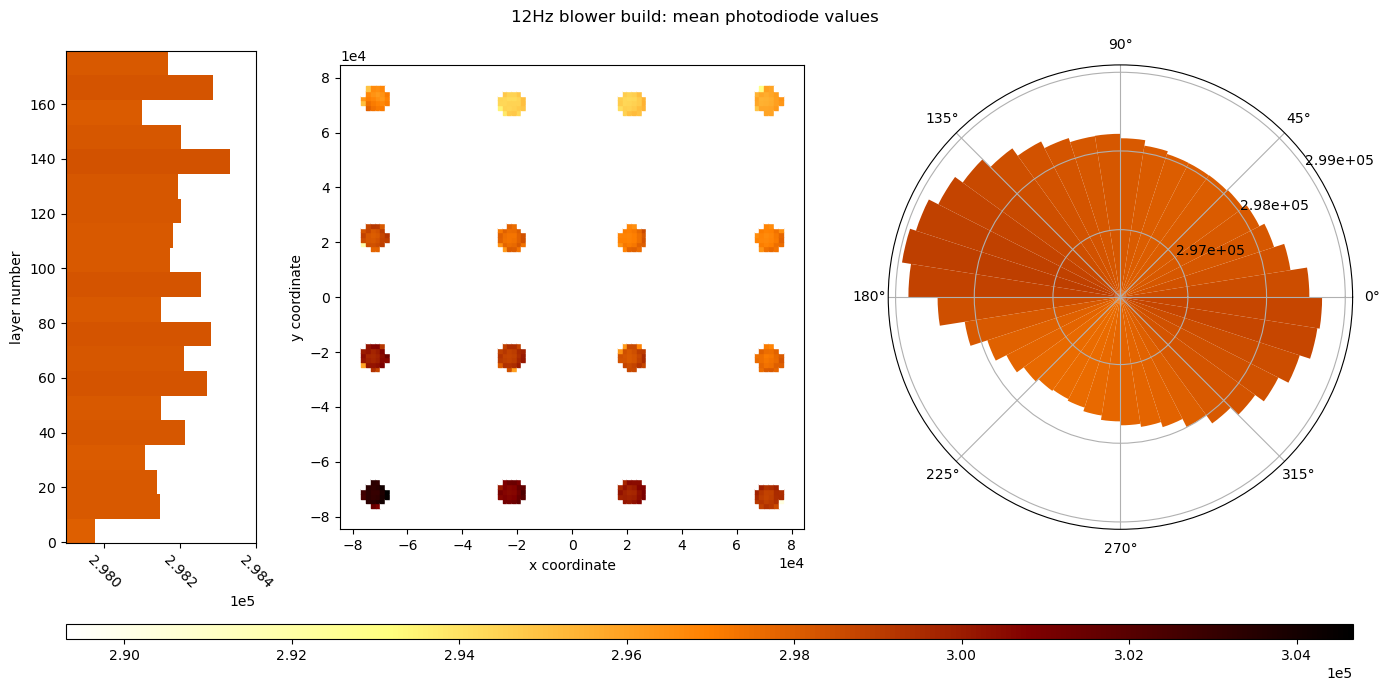

In [11]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_0 = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data,
                       th_data,
                       Zl_data,
                       "mean",
                       normalisation='linear')
fig.suptitle("12Hz blower build: mean photodiode values")
fig.tight_layout()

Note that in the second plot, `vrange` returned from the previous plotting function is passed as a variable in order to use the same value range and colorbar as above. 

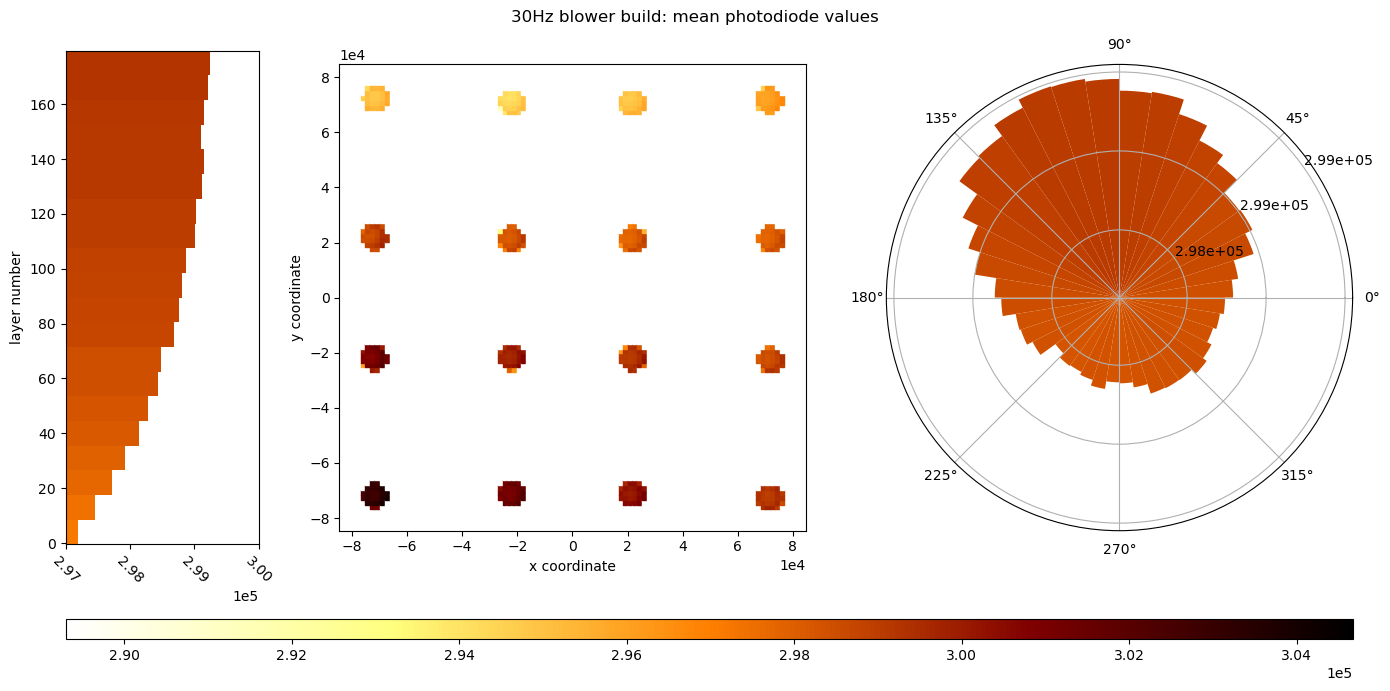

In [12]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_0 = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange_0,
                       quantity="mean",
                       normalisation='linear')
fig.suptitle("30Hz blower build: mean photodiode values")
fig.tight_layout()

For this second set of bins, the quantity shown is the average total spatter area per unit of distance traversed along the scan path. Note that you can add plot any ATLAS metric here. 

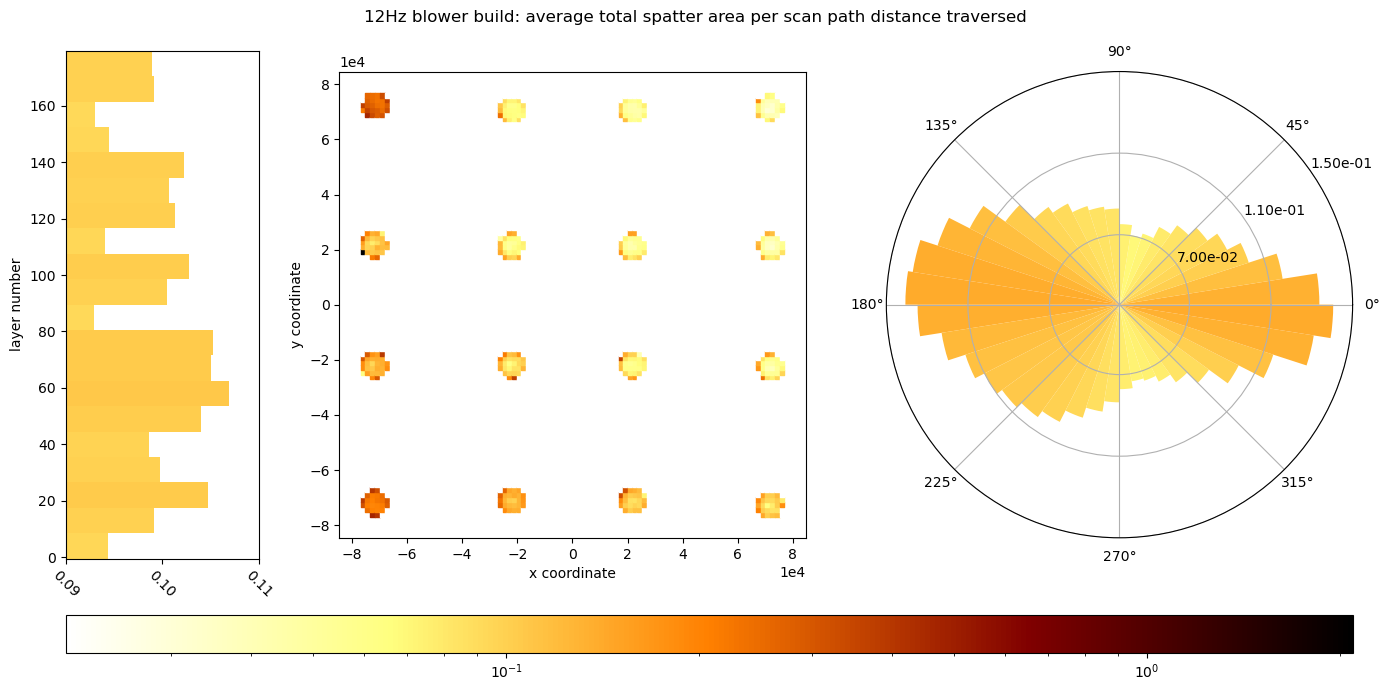

In [13]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_1 = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data,
                       th_data,
                       Zl_data,
                       "per_traversed",
                       normalisation='log')
fig.suptitle("12Hz blower build: average total spatter area per scan path distance traversed")
fig.tight_layout()

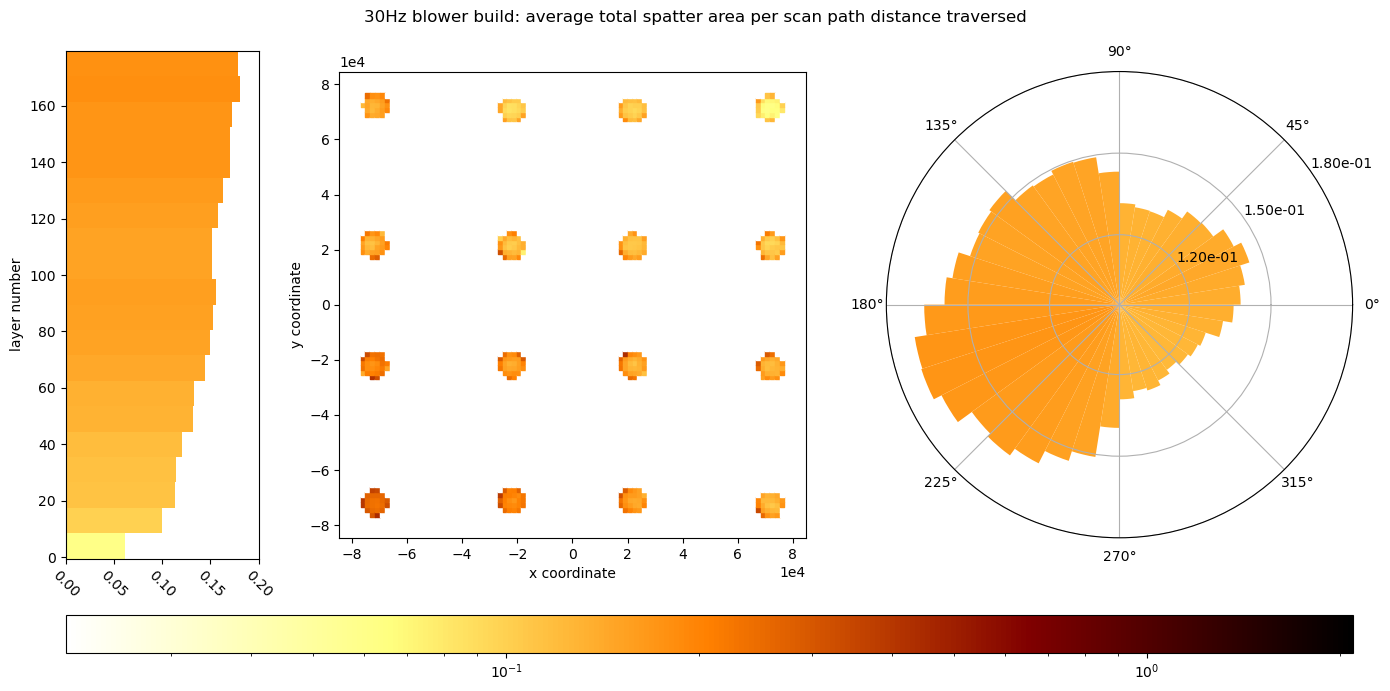

In [14]:
fig = plt.figure(figsize=(14.0,7.0))
ax_z,ax_xy,ax_th,vrange_1 = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange_1,
                       quantity="per_traversed",
                       normalisation='log')
fig.suptitle("30Hz blower build: average total spatter area per scan path distance traversed")
fig.tight_layout()

## Separate binning by component

In [15]:
# Once again, use the test file to work out a rough bin 'mesh' for the build bed plane bins. 
dir_ = "onderive_data_2/12Hz/"
test_path = dir_ + "layer360.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=1,
                                          aux_variable="P",
                                          tol=1000.0)

In [16]:
# Setup objects that correspond to the bins over 'coordinates' - here the rough mesh over XY is a proxy for the build components. 
th_component_data = fast_binning.DataBins(["X","Y","Orientation"],[x_grid,y_grid,np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)

In [17]:
# Note that due to the large overhead of reading .csv files, it would be faster to do this in the same loop as the one above. 
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df) # Calculate extra derived variables. 
    fast_binning.process_dataframe(df,th_component_data)

  0%|          | 0/180 [00:00<?, ?it/s]

DataBins objects can be sliced to produce a new DataBins object. How slices are taken should correspond to the order of the `coord_names` attribute. The code snippet in the cell below gives an example. 

In [18]:
print("original coords = [{},{},{}]".format(*th_component_data.coord_names))
print("original # bins per coord = [{},{},{}]".format(*th_component_data.nbin))
th_component_data_00 = th_component_data[0,0,:]
print("sliced object's coords = [{}]".format(*th_component_data_00.coord_names))
print("sliced object's # bins per coord = [{}]".format(*th_component_data_00.nbin))

original coords = [X,Y,Orientation]
original # bins per coord = [9,9,42]
sliced object's coords = [Orientation]
sliced object's # bins per coord = [42]


Can make use of slicing to plot orientation bins _per component_ i.e. per XY plane bin. 

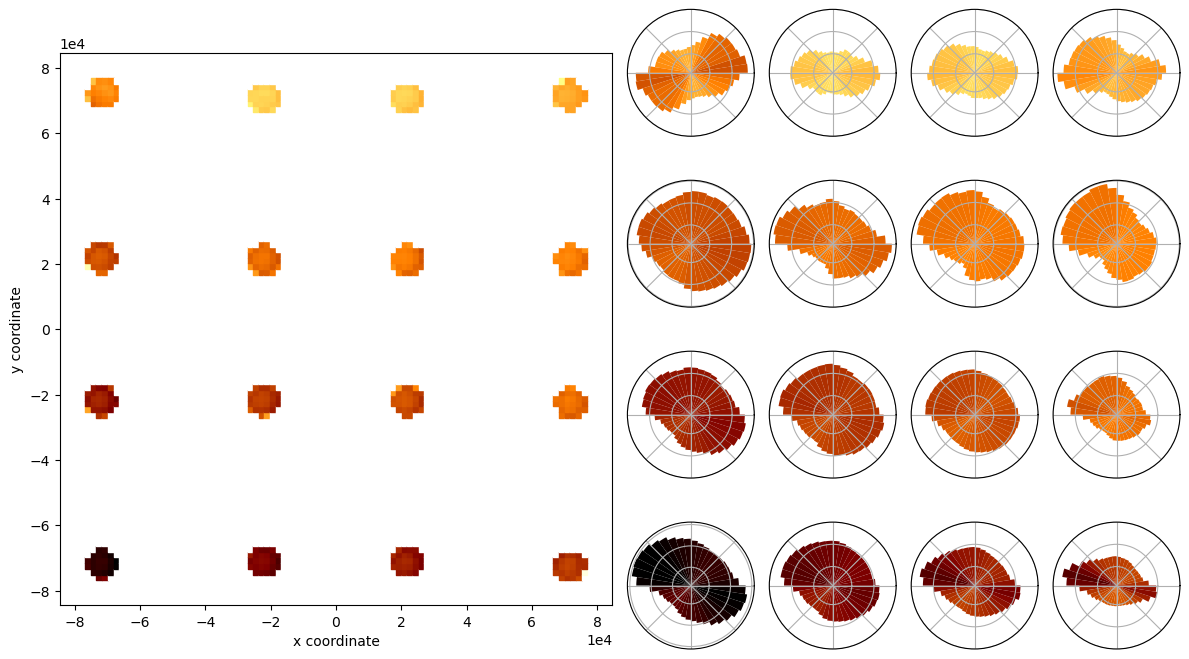

In [19]:
fig = plt.figure(figsize=(12,7))
spec = fig.add_gridspec(4,8)

# Just replot the planar data
ax0 = fig.add_subplot(spec[:,:4])
fast_binning.plot_planar_bins(ax0,XY_data,"Photodiode","mean",vrange=vrange_0)

# Now plot bins over orientation for each component.
# Note the strange indexing - component [0,0] is oat the bottom left of the planar plot. 
for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(spec[3-j,4+i],polar=True)
        fast_binning.plot_orientation_bins(ax,th_component_data[2*i,2*j,:],"Photodiode","mean",vrange=vrange_0)
        # Clean up these plots - they're too small for labels really
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
fig.tight_layout()

## Profiling the code
The main overhead is from reading in the csv files. 

In [20]:
from copy import deepcopy

In [21]:
XY_data_test = deepcopy(XY_data_30Hz)
th_data_test = deepcopy(th_data_30Hz)
Zl_data_test = deepcopy(Zl_data_30Hz)

In [22]:
%%prun
df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
df = fast_binning.expand_df(df)
fast_binning.process_dataframe(df,XY_data_test,th_data_test,Zl_data_test)

         324666 function calls (319052 primitive calls) in 2.865 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.709    1.709    1.738    1.738 {method 'read_low_memory' of 'pandas._libs.parsers.TextReader' objects}
      350    0.126    0.000    0.126    0.000 {pandas._libs.algos.take_2d_axis0_float64_float64}
 1225/881    0.110    0.000    0.137    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      314    0.082    0.000    0.082    0.000 {built-in method scipy.fft._pocketfft.pypocketfft.c2c}
      192    0.037    0.000    0.037    0.000 fast_binning.py:10(add_at)
     2609    0.031    0.000    0.031    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        4    0.030    0.007    0.030    0.007 managers.py:2194(_stack_arrays)
        1    0.026    0.026    0.027    0.027 c_parser_wrapper.py:60(__init__)
        2    0.025    0.012    0.056    0.028 managers.py:2224(_merge_b